In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams['legend.numpoints'] = 1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
def save(name,dpi=150):
    plt.savefig('img/'+name,bbox_inches='tight',dpi=dpi)
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,roc_auc_score,precision_recall_curve
from scipy.interpolate import interp1d
from hists import histratiobinomial, hist,drawhistratio
import pickle

In [2]:
def splitby(df,frac):
    sel1=np.random.rand(df.shape[0])<=frac
    sel2=~sel1
    df1=df[sel1]
    df2=df[sel2]
    return df1,df2

def renamecols(dfs):
    for df in dfs:
        df.rename(columns = {'# centralityBin':'centralityBin'},inplace=True)

def limitpt(d, pTmin, pTmax):
    return d[(d.Jet_pt>=pTmin) & (d.Jet_pt<pTmax)]

def prepareframes():
    print('Reading data')
    print('qcd30...')
    qcd30 =pd.read_pickle('data_qcd30.pkl')
    print('fcr30...')
    fcr30 =pd.read_pickle('data_fcr30.pkl')    
    print('qcd50...')
    qcd50 =pd.read_pickle('data_qcd50.pkl')
    print('fcr50...')
    fcr50 =pd.read_pickle('data_fcr50.pkl')
    print('qcd80...')
    qcd80 =pd.read_pickle('data_qcd80.pkl')
    print('fcr80...')
    fcr80 =pd.read_pickle('data_fcr80.pkl')
    print('qcd120...')
    qcd120=pd.read_pickle('data_qcd120.pkl')
    print('fcr120...')
    fcr120=pd.read_pickle('data_fcr120.pkl')
    print('qcd170...')
    qcd170=pd.read_pickle('data_qcd170.pkl')
    print('fcr170...')
    fcr170=pd.read_pickle('data_fcr170.pkl')
    print('Rename cols')
    renamecols([fcr80,qcd80,fcr50,qcd50,fcr120,qcd120])
    
    print('Limit pT in pThat')
    qcd30=limitpt(qcd30,30,50)
    fcr30=limitpt(fcr30,30,50)
    qcd50=limitpt(qcd50,50,80)
    fcr50=limitpt(fcr50,50,80)
    qcd80=limitpt(qcd80,80,120)
    fcr80=limitpt(fcr80,80,120)
    qcd120=limitpt(qcd120,120,170)
    fcr120=limitpt(fcr120,120,170)
    qcd170=limitpt(qcd170,170,300)
    fcr170=limitpt(fcr170,170,300)
    
    fcr = pd.concat([fcr30, fcr50,fcr80,fcr120,fcr170])
    qcd = pd.concat([qcd30, qcd50,qcd80,qcd120,qcd170])
    
    fcr.to_pickle('fcr3.pkl')
    qcd.to_pickle('qcd3.pkl')

In [3]:
def getdataset(fraction = 0.5):
    fcr = pd.read_pickle('fcr3a.pkl')
    qcd = pd.read_pickle('qcd3a.pkl')
    print('Split train/test')
    
    f1,f2=splitby(fcr,fraction)
    q1,q2=splitby(qcd,fraction)
    
    print('train set mixing')
    f1bjt=f1[f1.flavor==1]
    q1light=q1[q1.flavor!=1].sample(frac=1)
    train=pd.concat((f1bjt,q1light))
    train=train.sample(frac=1.0)
    
    print('done!')    
    return (train, f1,q1, f2, q2)

def getweights(d):
    weight=(d.flavor==0)*2+1
    return weight

In [4]:
#prepareframes()
d,fcrtrainall,qcdtrainall,fcrtestall,qcdtestall = getdataset(0.5)

Split train/test
train set mixing
done!


In [5]:
d['weight'] = getweights(d)

#check B vs C rejection
# fcrtest=fcrtestall[(fcrtestall.flavor==1) | (fcrtestall.flavorC==1)]
# qcdtest=qcdtestall[(qcdtestall.flavor==1) | (qcdtestall.flavorC==1)]

#check B vs LIGHT rejection
# fcrtest=fcrtestall[(fcrtestall.flavor==1) | (fcrtestall.flavorC==0)]
# qcdtest=qcdtestall[(qcdtestall.flavor==1) | (qcdtestall.flavorC==0)]

#check B vs ALL rejection
fcrtest=fcrtestall
qcdtest=qcdtestall

fname='alldata_w3_NEW_'

usexgb=False
trainAgain = True

if usexgb:
    fname+='xgb_'
else:
    fname+='skl_'

In [6]:
#pickle.dump((qcdtest,fcrtest), open(fname+"testdata.dat", "wb"))

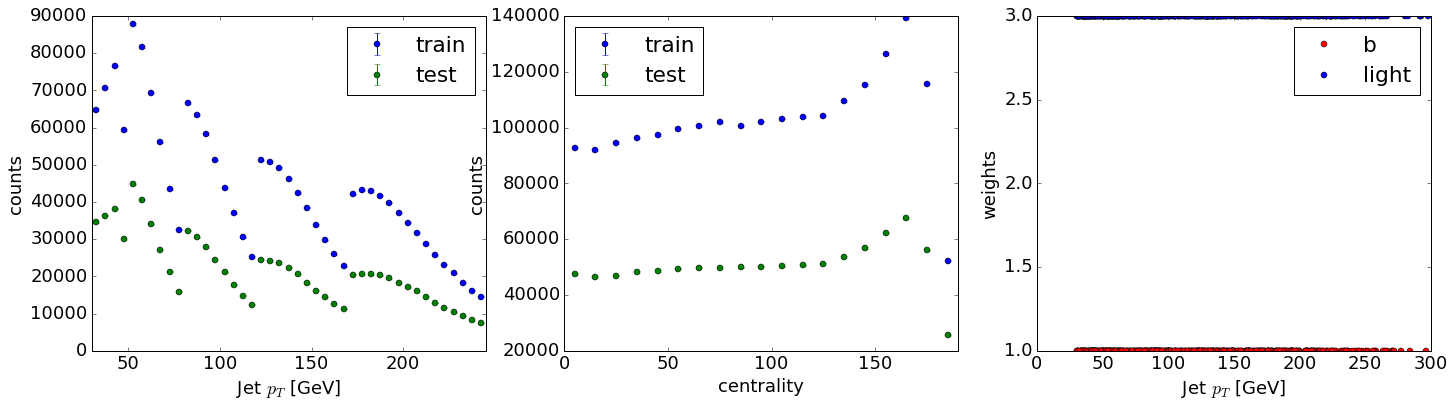

In [7]:
plt.figure(figsize=(24, 6))
plt.subplot(131)
b=np.arange(30,250,5)
_=hist(d.Jet_pt,bins=b,plot=True,label='train')
_=hist(qcdtest.Jet_pt,bins=b,plot=True,label='test')
plt.xlabel('Jet $p_{T}$ [GeV]')
plt.ylabel('counts')
plt.legend()

plt.subplot(132)
b=np.arange(0,200,10)
_=hist(d.centralityBin,bins=b,plot=True,label='train')
_=hist(qcdtest.centralityBin,bins=b,plot=True,label='test')
plt.xlabel('centrality')
plt.ylabel('counts')
plt.legend(loc=0)

plt.subplot(133)
ds=d.sample(1000)
plt.plot(ds.Jet_pt[ds.flavor==1],ds.weight[ds.flavor==1],'ro',label='b')
plt.plot(ds.Jet_pt[ds.flavor==0],ds.weight[ds.flavor==0],'bo',label='light')
plt.xlabel('Jet $p_{T}$ [GeV]')
plt.ylabel('weights')
plt.legend(loc=0)

save(fname+'traintestpTbinweight')

In [8]:
tagVars = [x for x in d.columns if x.startswith('TagVarCSV')]
len(tagVars)

38

In [9]:
y=d['flavor']

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    d, y, test_size=0.2, random_state=42,stratify=y)

weight=X_train.weight
testweigths = X_test.weight #used for plotting loss only!

X_train=X_train[tagVars]
X_test=X_test[tagVars]

print(X_train.shape)
print(X_test.shape)

(1561916, 38)
(390479, 38)


In [10]:
# models = [
#     {'depth':6, 'estimators':300, 'cls':'xgb'},
    
# ]

In [11]:
X_train.head()

,TagVarCSV_jetNTracks,TagVarCSV_trackSip3dSig_0,TagVarCSV_trackSip3dSig_1,TagVarCSV_trackSip3dSig_2,TagVarCSV_trackSip3dSig_3,TagVarCSV_trackSip3dSigAboveCharm,TagVarCSV_trackPtRel_0,TagVarCSV_trackPtRel_1,TagVarCSV_trackPtRel_2,TagVarCSV_trackPtRel_3,...,TagVarCSV_trackDecayLenVal_2,TagVarCSV_trackDecayLenVal_3,TagVarCSV_trackSumJetEtRatio,TagVarCSV_trackSumJetDeltaR,TagVarCSV_vertexMass,TagVarCSV_vertexNTracks,TagVarCSV_vertexEnergyRatio,TagVarCSV_vertexJetDeltaR,TagVarCSV_flightDistance2dSig,TagVarCSV_jetNSecondaryVertices
379197,5,1.074122,5.203640,-1.027483,2.565561,3.740423,0.260565,0.372092,0.174025,0.024767,...,0.079388,0.154509,0.712886,0.018556,-1.000000,0,-1.000000,-1.000000,-1.000000,0
929921,4,28.314888,13.311472,2.627339,-0.047791,13.311472,1.397932,0.370298,0.043446,0.165525,...,2.582255,0.001640,0.447611,0.010354,4.234005,3,0.831743,0.002790,30.642429,1
465664,4,14.978782,9.939978,-0.544543,-0.442304,-0.544543,0.414895,0.452203,0.332171,0.343702,...,0.009418,0.021973,0.587054,0.057398,1.385739,2,0.772923,0.019323,7.429840,1
362269,8,23.892633,2.683488,1.931920,1.141822,2.136702,1.220637,0.256322,0.237938,0.957089,...,0.201579,0.237381,0.682061,0.061646,1.879559,2,0.365480,0.053752,22.624569,1
361338,1,-0.863324,-99.000000,-99.000000,-99.000000,-1.000000,0.576602,-1.000000,-1.000000,-1.000000,...,-0.100000,-0.100000,0.041399,0.225380,-1.000000,0,-1.000000,-1.000000,-1.000000,0


In [12]:
if trainAgain:
    if usexgb:
        print('Using XGBoost')
        gbm = xgb.XGBClassifier(max_depth=6, n_estimators=500, nthread=8, learning_rate=0.01,silent=False,subsample=0.5)
        gbm.fit(X_train, y_train, weight, early_stopping_rounds=50, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=True)
        pickle.dump(gbm, open(fname+"model.xgb", "wb"))
        print(gbm.best_score)
        print(gbm.best_iteration)
    else:
        print('Using sklearn')
        gbm = GradientBoostingClassifier(max_depth=6, n_estimators=500 ,learning_rate = 0.01,subsample=0.5,verbose = 3)
        #min_frac_samples_split = 0.006
        #gbm = GradientBoostingClassifier(n_estimators=500,min_samples_split = int(min_frac_samples_split*y_train.shape[0]), learning_rate = 0.05, max_depth=15, verbose = 3)
        gbm.fit(X_train, y_train,weight)
        pickle.dump(gbm, open(fname+"model.skl", "wb"))
else:
    gbm = pickle.load(open("alldata_w3_OLD_xgb_model.xgb", "rb"))

Using XGBoost
[0]	validation_0-logloss:0.687763	validation_1-logloss:0.687766
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.682503	validation_1-logloss:0.682511
[2]	validation_0-logloss:0.67735	validation_1-logloss:0.677362
[3]	validation_0-logloss:0.672309	validation_1-logloss:0.672325
[4]	validation_0-logloss:0.667378	validation_1-logloss:0.667391
[5]	validation_0-logloss:0.662548	validation_1-logloss:0.662563
[6]	validation_0-logloss:0.657803	validation_1-logloss:0.65782
[7]	validation_0-logloss:0.653152	validation_1-logloss:0.653173
[8]	validation_0-logloss:0.648614	validation_1-logloss:0.648637
[9]	validation_0-logloss:0.644161	validation_1-logloss:0.644188
[10]	validation_0-logloss:0.639797	validation_1-logloss:0.639826
[11]	validation_0-logloss:0.635516	validation_1-logloss:0.63555
[12]	validation_0-logloss:0.631325	validation_1-loglos

In [ ]:
#gbm = pickle.load(open(fname+"model.skl", "rb"))

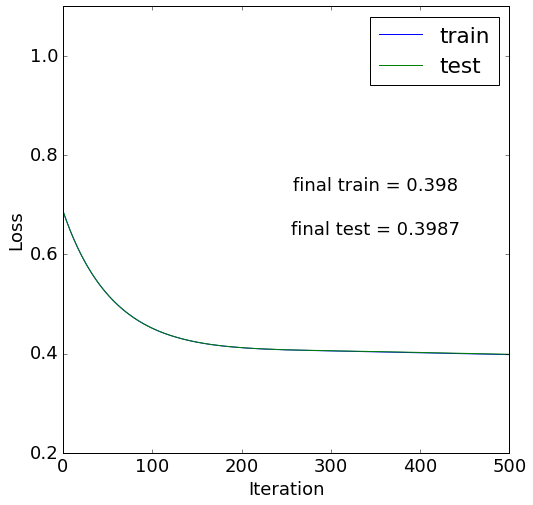

In [31]:
if usexgb:
    finaltrainloss = gbm.evals_result_['validation_0']['logloss'][-1]
    finaltestloss = gbm.evals_result_['validation_1']['logloss'][-1]
    trainloss = gbm.evals_result_['validation_0']['logloss']
    testloss = gbm.evals_result_['validation_1']['logloss']
else:
    finaltrainloss = gbm.train_score_[-1]
    finaltestloss = gbm.loss_(y_test,list(gbm.staged_decision_function(X_test))[-1],testweigths)#train_score_[0]-sum(gbm.oob_improvement_)
    trainloss =gbm.train_score_
    testloss = [gbm.loss_(y_test,pred,testweigths) for pred in gbm.staged_decision_function(X_test)]#gbm.train_score_[0]-np.cumsum(gbm.oob_improvement_)

plt.figure(figsize=(8, 8))
plt.plot(trainloss,label='train')
plt.plot(testloss,label='test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim((0.2,1.1))
plt.legend()
ax = plt.gca()
plt.text(0.7,0.6,'final train = {:.4}'.format(finaltrainloss),
         horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.text(0.7,0.5,'final test = {:.4}'.format(finaltestloss),
         horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

save(fname+'loss')

In [32]:
#gbm = pickle.load(open(fname+"model.xgb", "rb"))
fname

'alldata_w3_NEW_xgb_'

In [33]:
#fcrtest=fcrtrain
#qcdtest=qcdtrain
#fname='alldata_w3_skl__train_'

In [34]:
qcdtest.rename(columns = {'CSV':'Jet_CSV','CSVV2':'Jet_CSVV2'},inplace=True)
fcrtest.rename(columns = {'CSV':'Jet_CSV','CSVV2':'Jet_CSVV2'},inplace=True)

In [35]:
qcdtest.columns

Index(['centralityBin', 'Jet_pt', 'Jet_eta', 'Jet_flavour', 'Jet_CSV',
       'Jet_CSVV2', 'Jet_genpt', 'TagVarCSV_jetNTracks',
       'TagVarCSV_trackSip3dSig_0', 'TagVarCSV_trackSip3dSig_1',
       'TagVarCSV_trackSip3dSig_2', 'TagVarCSV_trackSip3dSig_3',
       'TagVarCSV_trackSip3dSigAboveCharm', 'TagVarCSV_trackPtRel_0',
       'TagVarCSV_trackPtRel_1', 'TagVarCSV_trackPtRel_2',
       'TagVarCSV_trackPtRel_3', 'TagVarCSV_trackEtaRel_0',
       'TagVarCSV_trackEtaRel_1', 'TagVarCSV_trackEtaRel_2',
       'TagVarCSV_trackEtaRel_3', 'TagVarCSV_trackDeltaR_0',
       'TagVarCSV_trackDeltaR_1', 'TagVarCSV_trackDeltaR_2',
       'TagVarCSV_trackDeltaR_3', 'TagVarCSV_trackPtRatio_0',
       'TagVarCSV_trackPtRatio_1', 'TagVarCSV_trackPtRatio_2',
       'TagVarCSV_trackPtRatio_3', 'TagVarCSV_trackJetDist_0',
       'TagVarCSV_trackJetDist_1', 'TagVarCSV_trackJetDist_2',
       'TagVarCSV_trackJetDist_3', 'TagVarCSV_trackDecayLenVal_0',
       'TagVarCSV_trackDecayLenVal_1', 'TagVarCSV_tr

In [49]:
pTconditionFCR = (fcrtest.Jet_pt > 60) & (fcrtest.Jet_pt < 140)# & (fcrtest.centralityBin<20)
pTconditionQCD = (qcdtest.Jet_pt > 60) & (qcdtest.Jet_pt < 140)# & (qcdtest.centralityBin<20)

fcrpred=gbm.predict_proba(fcrtest[tagVars])[:,1]
qcdpred=gbm.predict_proba(qcdtest[tagVars])[:,1]
fcrtrue=fcrtest.flavor
qcdtrue=qcdtest.flavor
fcrcsv = fcrtest.Jet_CSV
qcdcsv = qcdtest.Jet_CSV#CSV
fcrcsv2 = fcrtest.Jet_CSVV2#.CSVV2
qcdcsv2 = qcdtest.Jet_CSVV2#.CSVV2

fcrtrue=fcrtrue[pTconditionFCR.values]
qcdtrue=qcdtrue[pTconditionQCD.values]
fcrcsv = fcrcsv[pTconditionFCR.values]
qcdcsv = qcdcsv[pTconditionQCD.values]
fcrcsv2=fcrcsv2[pTconditionFCR.values]
qcdcsv2=qcdcsv2[pTconditionQCD.values]
fcrpredmidpt=fcrpred[pTconditionFCR.values]
qcdpredmidpt=qcdpred[pTconditionQCD.values]


precision_pred_f, recall_pred_f, th_pred_f = precision_recall_curve(fcrtrue,fcrpredmidpt)
precision_pred_q, recall_pred_q, th_pred_q = precision_recall_curve(qcdtrue,qcdpredmidpt)

precision_csv_f, recall_csv_f, th_csv_f = precision_recall_curve(fcrtrue,fcrcsv)
precision_csv_q, recall_csv_q, th_csv_q = precision_recall_curve(qcdtrue,qcdcsv)

precision_csv2_f, recall_csv2_f, th_csv2_f = precision_recall_curve(fcrtrue,fcrcsv2)
precision_csv2_q, recall_csv2_q, th_csv2_q = precision_recall_curve(qcdtrue,qcdcsv2)

N=np.where(precision_pred_q>precision_csv_q[1])[0][0]
N=max(N,np.where(precision_csv2_q>precision_csv_q[1])[0][0])+100

th_CSV_predX=interp1d(precision_csv_q[1:],th_csv_q)(precision_pred_q[N:])
th_CSV_csv2X=interp1d(precision_csv_q[1:],th_csv_q)(precision_csv2_q[N:])

thCSV=0.9
thBDT = float(interp1d(th_CSV_predX[1:],th_pred_q[N:])(thCSV))
thCSVv2 = float(interp1d(th_CSV_csv2X[1:],th_csv2_q[N:])(thCSV))


ind = np.where(th_csv_q>0.9)[0][0]
pur = precision_csv_q[ind]

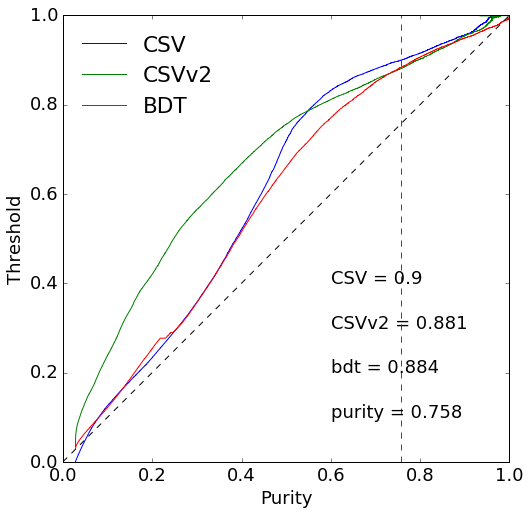

In [50]:
plt.figure(figsize=(8, 8))
plt.plot(precision_csv_q[1:],th_csv_q,label='CSV')
plt.plot(precision_csv2_q[1:][th_csv2_q>0],th_csv2_q[th_csv2_q>0],label='CSVv2')
plt.plot(precision_pred_q[1:],th_pred_q,label='BDT')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Purity')
plt.ylabel('Threshold')



plt.annotate('CSV = {:.3}'.format(float(thCSV)),(0.6,0.4))
plt.annotate('CSVv2 = {:.3}'.format(float(thCSVv2)),(0.6,0.3))
plt.annotate('bdt = {:.3}'.format(float(thBDT)),(0.6,0.2))
plt.annotate('purity = {:.3}'.format(float(pur)),(0.6,0.1))

plt.axvline(pur,linestyle='--', color='g')
plt.legend(loc=2,frameon=False)
plt.ylim((0,1))
save(fname+'pur_th')

In [51]:
#thBDT=0.921
#thCSVv2=0.882

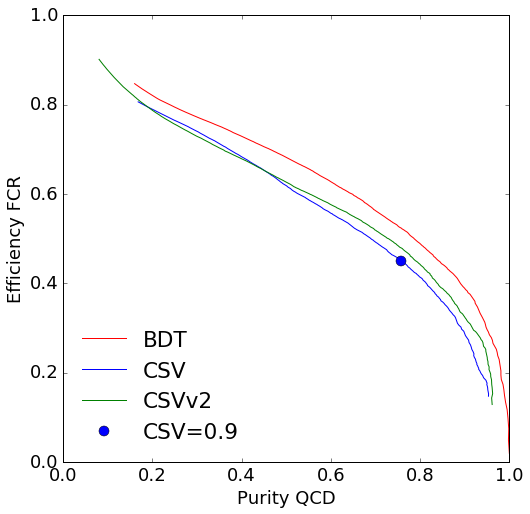

In [52]:
myth = np.arange(0.2,min(max(th_pred_q),0.996),0.001)

myprecision_pred_q = interp1d(th_pred_q,precision_pred_q[1:])(myth)
myprecision_csv_q = interp1d(th_csv_q,precision_csv_q[1:])(myth)
myprecision_csv2_q = interp1d(th_csv2_q,precision_csv2_q[1:])(myth)
myrecall_pred_f = interp1d(th_pred_f,recall_pred_f[1:])(myth)
myrecall_csv_f = interp1d(th_csv_f,recall_csv_f[1:])(myth)
myrecall_csv2_f = interp1d(th_csv2_f,recall_csv2_f[1:])(myth)
csv09=np.where(myth>0.9)[0][0]

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(myprecision_pred_q, myrecall_pred_f,  color='red', label='BDT')
plt.plot(myprecision_csv_q, myrecall_csv_f,  color='blue', label='CSV')
plt.plot(myprecision_csv2_q, myrecall_csv2_f,  color='green', label='CSVv2')
xarr,yarr=myprecision_csv_q[csv09],myrecall_csv_f[csv09]
#plt.annotate('csv=0.9', xy=(xarr,yarr), xytext=(xarr-0.2,yarr-0.1),arrowprops=dict(facecolor='black', shrink=0.05))

plt.plot(myprecision_csv_q[csv09],myrecall_csv_f[csv09],'bo',markersize=10,label='CSV=0.9')

plt.xlim((0,1))
plt.xlabel('Purity QCD')
plt.ylabel('Efficiency FCR')
plt.legend(loc=3,frameon=False)
save(fname+'purqcd_efffcr')

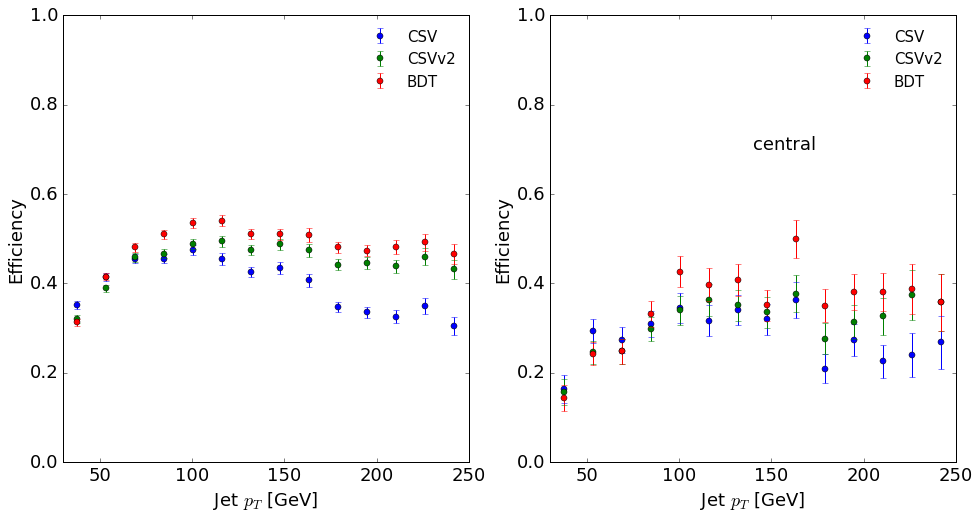

In [53]:
plt.figure(figsize=(16, 8))

b=np.linspace(30,250,15)

plt.subplot(121)
drawhistratio("CSV",  qcdtest.Jet_pt,((qcdtest.flavor==1) & (qcdtest.Jet_CSV>thCSV)),    (qcdtest.flavor==1),b)
drawhistratio("CSVv2",qcdtest.Jet_pt,((qcdtest.flavor==1) & (qcdtest.Jet_CSVV2>thCSVv2)),(qcdtest.flavor==1),b)
drawhistratio("BDT",  qcdtest.Jet_pt,((qcdtest.flavor==1) & (qcdpred>thBDT)),        (qcdtest.flavor==1),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Efficiency')
plt.xlabel('Jet $p_{T}$ [GeV]')

plt.ylim((0,1))


plt.subplot(122)
drawhistratio("CSV",  qcdtest.Jet_pt,((qcdtest.centralityBin<20) & (qcdtest.flavor==1) & (qcdtest.Jet_CSV>thCSV)),    (qcdtest.centralityBin<20) & (qcdtest.flavor==1),b)
drawhistratio("CSVv2",qcdtest.Jet_pt,((qcdtest.centralityBin<20) & (qcdtest.flavor==1) & (qcdtest.Jet_CSVV2>thCSVv2)),(qcdtest.centralityBin<20) & (qcdtest.flavor==1),b)
drawhistratio("BDT",  qcdtest.Jet_pt,((qcdtest.centralityBin<20) & (qcdtest.flavor==1) & (qcdpred>thBDT)),        (qcdtest.centralityBin<20) & (qcdtest.flavor==1),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Efficiency')
plt.xlabel('Jet $p_{T}$ [GeV]')
plt.text(140,0.7,'central')

plt.ylim((0,1))



save(fname+'eff_pT')

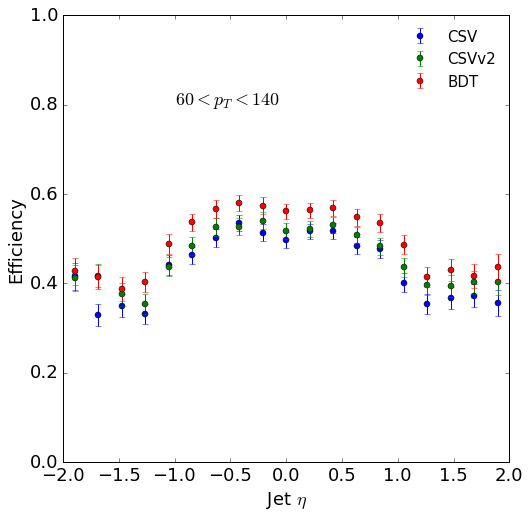

In [54]:
plt.figure(figsize=(8, 8))

b=np.linspace(-2.0,2.0,20)

drawhistratio("CSV",  qcdtest.Jet_eta,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1) & (qcdtest.Jet_CSV>thCSV)),    (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1),b)
drawhistratio("CSVv2",qcdtest.Jet_eta,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1) & (qcdtest.Jet_CSVV2>thCSVv2)),(qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1),b)
drawhistratio("BDT",  qcdtest.Jet_eta,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1) & (qcdpred>thBDT)),        (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Efficiency')
plt.xlabel('Jet $\eta$')

plt.text(-1,0.8,'$60<p_{T}<140$')

plt.ylim((0,1))
save(fname+'eff_eta')

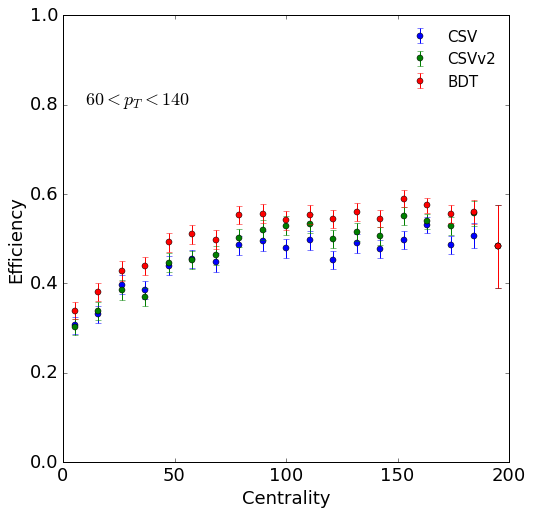

In [55]:
plt.figure(figsize=(8, 8))

b=np.linspace(0,200,20)

drawhistratio("CSV",  qcdtest.centralityBin,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1) & (qcdtest.Jet_CSV>thCSV)),    (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1),b)
drawhistratio("CSVv2",qcdtest.centralityBin,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1) & (qcdtest.Jet_CSVV2>thCSVv2)),(qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1),b)
drawhistratio("BDT",  qcdtest.centralityBin,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1) & (qcdpred>thBDT)),        (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.flavor==1),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Efficiency')
plt.xlabel('Centrality')

plt.text(10,0.8,'$60<p_{T}<140$')

plt.ylim((0,1))
save(fname+'eff_bin')

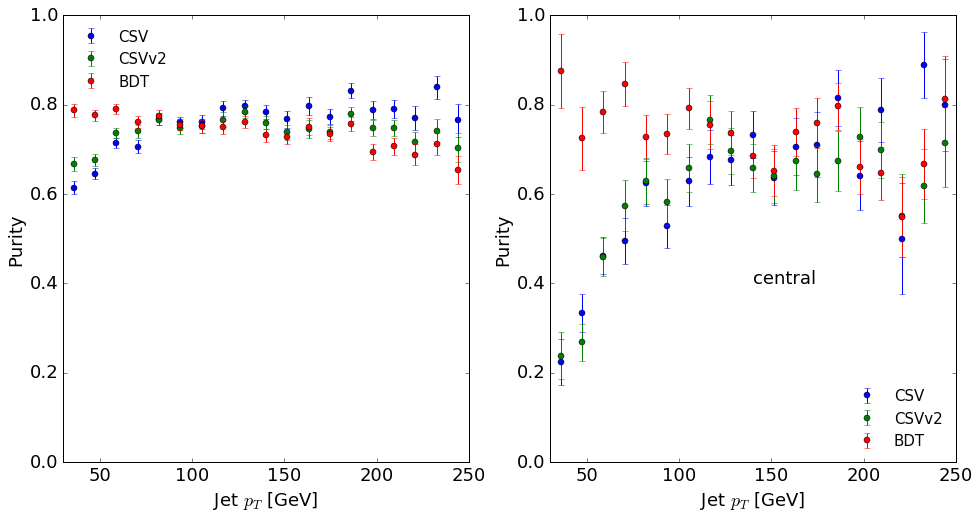

In [56]:
plt.figure(figsize=(16, 8))

b=np.linspace(30,250,20)

plt.subplot(121)
drawhistratio("CSV",  qcdtest.Jet_pt,((qcdtest.Jet_CSV>thCSV) & (qcdtest.flavor==1)),    (qcdtest.Jet_CSV>thCSV),b)
drawhistratio("CSVv2",qcdtest.Jet_pt,((qcdtest.Jet_CSVV2>thCSVv2) & (qcdtest.flavor==1)),(qcdtest.Jet_CSVV2>thCSVv2),b)
drawhistratio("BDT",  qcdtest.Jet_pt,((qcdpred>thBDT) & (qcdtest.flavor==1)),        (qcdpred>thBDT),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Purity')
plt.xlabel('Jet $p_{T}$ [GeV]')

plt.ylim((0,1))

plt.subplot(122)
drawhistratio("CSV",  qcdtest.Jet_pt,((qcdtest.centralityBin<20) & (qcdtest.Jet_CSV>thCSV) & (qcdtest.flavor==1)),    (qcdtest.centralityBin<20) & (qcdtest.Jet_CSV>thCSV),b)
drawhistratio("CSVv2",qcdtest.Jet_pt,((qcdtest.centralityBin<20) & (qcdtest.Jet_CSVV2>thCSVv2) & (qcdtest.flavor==1)),(qcdtest.centralityBin<20) & (qcdtest.Jet_CSVV2>thCSVv2),b)
drawhistratio("BDT",  qcdtest.Jet_pt,((qcdtest.centralityBin<20) & (qcdpred>thBDT) & (qcdtest.flavor==1)),        (qcdtest.centralityBin<20) & (qcdpred>thBDT),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Purity')
plt.xlabel('Jet $p_{T}$ [GeV]')
plt.text(140,0.4,'central')

plt.ylim((0,1))


save(fname+'pur_pT')

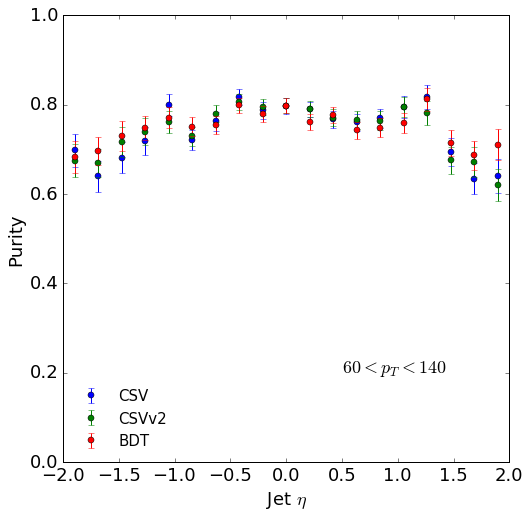

In [57]:
plt.figure(figsize=(8, 8))

b=np.linspace(-2.0,2.0,20)

drawhistratio("CSV",  qcdtest.Jet_eta,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSV>thCSV) & (qcdtest.flavor==1)),    (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSV>thCSV),b)
drawhistratio("CSVv2",qcdtest.Jet_eta,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSVV2>thCSVv2) & (qcdtest.flavor==1)),(qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSVV2>thCSVv2),b)
drawhistratio("BDT",  qcdtest.Jet_eta,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdpred>thBDT) & (qcdtest.flavor==1)),        (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdpred>thBDT),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Purity')
plt.xlabel('Jet $\eta$')

plt.text(0.5,0.2,'$60<p_{T}<140$')

plt.ylim((0,1))
save(fname+'pur_eta')

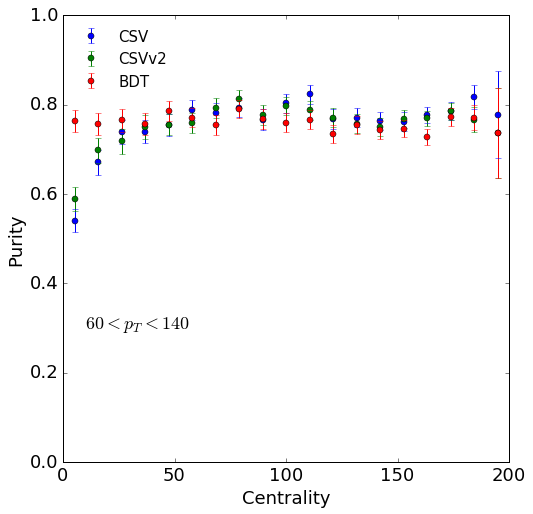

In [58]:
plt.figure(figsize=(8, 8))

b=np.linspace(0,200,20)

drawhistratio("CSV",  qcdtest.centralityBin,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSV>thCSV) & (qcdtest.flavor==1)),    (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSV>thCSV),b)
drawhistratio("CSVv2",qcdtest.centralityBin,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSVV2>thCSVv2) & (qcdtest.flavor==1)),(qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdtest.Jet_CSVV2>thCSVv2),b)
drawhistratio("BDT",  qcdtest.centralityBin,((qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdpred>thBDT) & (qcdtest.flavor==1)),        (qcdtest.Jet_pt>60) & (qcdtest.Jet_pt<140) & (qcdpred>thBDT),b)

plt.legend(loc=0,frameon=False,framealpha=0,fontsize='small')
plt.ylabel('Purity')
plt.xlabel('Centrality')

plt.text(10,0.3,'$60<p_{T}<140$')

plt.ylim((0,1))
save(fname+'pur_bin')

In [47]:
#output TMVAweights
#import importlib
#importlib.reload(sklearn_to_tmva)
import sklearn_to_tmva


In [48]:
sklearn_to_tmva.gbr_to_tmva(gbm,qcdtest[tagVars].values,'TMVA_weights.xml',var_names=tagVars)

AttributeError: 'XGBClassifier' object has no attribute 'n_features'